In [1]:
import timeit
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label
import pyclesperanto_prototype as proto
import pyclesperanto as cle

cle.select_device()
cle.set_wait_for_kernel_to_finish(True)

proto.select_device()
proto.set_wait_for_kernel_finish(True)

sizes = np.arange(1, 100, 10)

warmup_iter = 1
eval_iter = 3

seed_value = 42

pyclesperanto version: 0.6.6a1


In [2]:
def mb_to_bytes(mb:int = 1) -> int:
    return mb * 1024 * 1024

def shape_from_elements(bytes:int) -> tuple:
    elements = bytes / 4
    shape = int(np.power(elements, 1/3))
    return (shape, shape, shape)

def generate_random_blob_image(size:int = 128) -> np.ndarray:
    """
    Generates a random image of given size and sigma.
    """
    shape = shape_from_elements(mb_to_bytes(size))
    image = np.zeros(shape, dtype=np.float32)
    # generate random blobs in image
    nb_blobs = int(shape[0] * shape[1] * shape[2] // 1000)
    x = np.random.randint(0, shape[0], nb_blobs)
    y = np.random.randint(0, shape[1], nb_blobs)
    z = np.random.randint(0, shape[2], nb_blobs)
    image[x, y, z] = 1
    image = gaussian(image, sigma=10)  

    return image

def benchmark_function(target_function, operation:str, framework:str) -> pd.DataFrame:
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    np.random.seed(seed_value)
    benchmark_data = []
    for size in sizes:
        # make new data
        image = generate_random_blob_image(size)
        size_mb = image.size * image.itemsize / 1024 / 1024
        # bind target function to given image
        partial_function = partial(target_function, image)
        # warmup       
        _ = timeit.timeit(partial_function, number=warmup_iter)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=eval_iter)
        
        print(f"Processing {image.shape} of {size_mb} Mb with {framework}... {time_in_s} s")

        # store results
        benchmark_data.append(pd.DataFrame({"benchmark": operation, "framework": framework, "size": size_mb, "time": time_in_s}, index=[0]))
    return pd.concat(benchmark_data)

# Prototype

In [3]:
def prototype_function(image):
    blurred = proto.gaussian_blur(source=image, sigma_x=3, sigma_y=3, sigma_z=3)
    binary = proto.threshold_otsu(source=blurred)
    labeled = proto.connected_components_labeling_box(binary_input=binary)

In [4]:
benchmark_data_prototype = benchmark_function(prototype_function, "mini pipeline", "prototype")

Processing (63, 63, 63) of 0.9538536071777344 Mb with prototype... 0.10141716903308406 s
Processing (142, 142, 142) of 10.922576904296875 Mb with prototype... 0.31401915597962216 s
Processing (176, 176, 176) of 20.796875 Mb with prototype... 0.40069758502068 s
Processing (201, 201, 201) of 30.97763442993164 Mb with prototype... 3.194064547016751 s
Processing (220, 220, 220) of 40.618896484375 Mb with prototype... 4.302431268966757 s


# Pyclic

In [5]:
def pycle_function(image):
    blurred = cle.gaussian_blur(input_image=image, sigma_x=3, sigma_y=3, sigma_z=3)
    binary = cle.threshold_otsu(input_image=blurred)
    labeled = cle.connected_components_labeling_box(input_image=binary)

In [6]:
benchmark_data_pycle = benchmark_function(pycle_function, "mini pipeline", "pyclesperanto")

Processing (63, 63, 63) of 0.9538536071777344 Mb with pyclesperanto... 0.03006129601271823 s
Processing (142, 142, 142) of 10.922576904296875 Mb with pyclesperanto... 0.22240667103324085 s
Processing (176, 176, 176) of 20.796875 Mb with pyclesperanto... 0.3046516799950041 s
Processing (201, 201, 201) of 30.97763442993164 Mb with pyclesperanto... 0.3554006320191547 s
Processing (220, 220, 220) of 40.618896484375 Mb with pyclesperanto... 1.5671955680008978 s


# Skimage

In [7]:
def skimage_function(image):
    blurred = gaussian(image, sigma=3)
    binary = blurred > threshold_otsu(blurred)
    labeled = label(binary)

In [8]:
benchmark_data_skimage = benchmark_function(skimage_function, "mini pipeline", "scikit-image")

Processing (63, 63, 63) of 0.9538536071777344 Mb with scikit-image... 0.038414233014918864 s
Processing (142, 142, 142) of 10.922576904296875 Mb with scikit-image... 0.3818136940244585 s
Processing (176, 176, 176) of 20.796875 Mb with scikit-image... 0.7399580529890954 s
Processing (201, 201, 201) of 30.97763442993164 Mb with scikit-image... 1.2893259210395627 s
Processing (220, 220, 220) of 40.618896484375 Mb with scikit-image... 1.6854657820076682 s


# Quantification

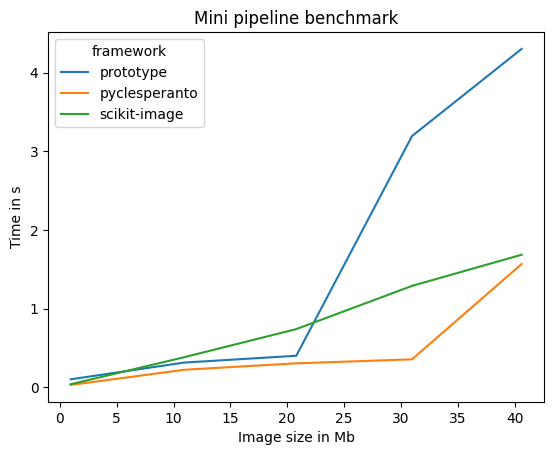

In [9]:
import seaborn as sns

benchmark_data = pd.concat([benchmark_data_prototype, benchmark_data_pycle, benchmark_data_skimage])

sns.lineplot(data=benchmark_data, x="size", y="time", hue="framework")
plt.title("Mini pipeline benchmark")
plt.xlabel("Image size in Mb")
plt.ylabel("Time in s")
plt.show()